# First assignment: Compute different measures on a realistic graph

In [32]:
import numpy as np
import urllib.request as urllib
import io
import zipfile

import networkx as nx
import matplotlib.pyplot as plt
import scipy
import collections
import random

## Load dataset

In [22]:


def load_dataset(sample = False, K = None):
    
    # if sample == True then only K randomly selected nodes are loaded
    
    # create graph
    G = nx.Graph()
    node_list = []

    with open("dataset/facebook_combined.edges") as edges:
        
        
        for row in edges:
            if len(row.split(" ")) == 1:
                continue
        
            source, target = row.split(" ")[:2]
            source = int(source)
            target = int(target)
            
            # add all the nodes and the edges
            if not sample:
                # add nodes if not in yet
                if source not in G:
                    G.add_node(source)
        
                if target not in G:
                    G.add_node(target)
        
                # add edge
                G.add_edge(source, target)
                
            else:
                # prepare the list to randomply sample
                
                if source not in node_list:
                    node_list.append(source)
                    
                if target not in node_list:
                    node_list.append(target)
        
        if sample:
            node_list = random.sample(node_list , k = K)
                    
            # add all the selected node
            for node in node_list:
                    if node not in G:
                        G.add_node(node)
                            
            # add all the edges linking the selected nodes
            for row in edges:
                if len(row.split(" ")) == 1:
                    continue
        
                source, target = row.split(" ")[:2]
                source = int(source)
                target = int(target)
                
                if source in G and target in G:
                    # add edge
                    G.add_edge(source, target)
        return G

# load graph with all nodes
G = load_dataset()


In [23]:
# number of nodes
N = nx.number_of_nodes(G)
print("Number of nodes: ", N)

# number of links
print("Number of edges: ", nx.number_of_edges(G))

# average degree
print("Average degree: ", sum([d for n, d in G.degree()])/nx.number_of_nodes(G))

# Density
print("Density: ", nx.density(G))

# Global clustering
print("Global clustering: ", nx.traversity(G))

# Average clustering
print("Average clustering: ", nx.average_clustering(G))


Number of nodes:  4039
Number of edges:  88234
Average degree:  43.69101262688784


### Compute metrics

#### Find the largest connected component if necessary

In [9]:
if not nx.is_connected(G):
    print("graph not connected! From now on the largest component will be considered as the graph")  
    G =  G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0]).copy()
    
print("Number of nodes of the giant component: ", nx.number_of_nodes(G))


Number of nodes of the giant component:  4039
Network Density:  0.010819963503439287


#### 1.Does the graph have the same characteristics of a random or a power-law network?

In [15]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def nth_moment(g,n):
    s = 0
    for node in g.nodes:
        s += g.degree[node] ** n
    return (s/len(g))

def nth_moment_v2(g,n):
    degree_np = np.array(list(dict(g.degree).values()))
    return (sum(degree_np**n)/len(g))

<ipython-input-15-ffd89fa73f36>:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


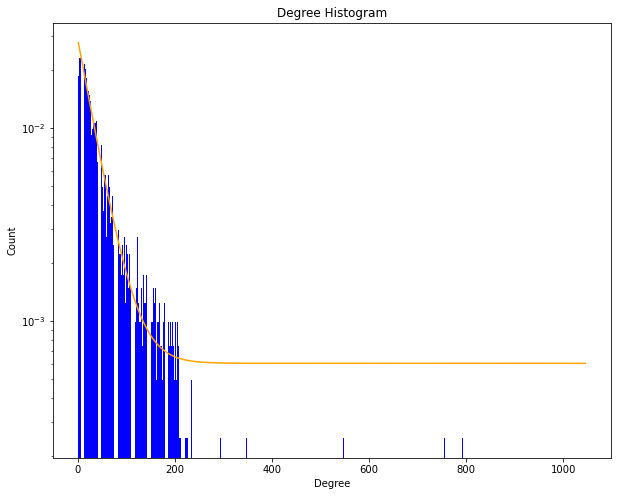

In [38]:
plt.figure(figsize=(10, 8))

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

#fig, ax = plt.subplots()
plt.bar(deg, np.array(cnt)/nx.number_of_nodes(G), width=0.80, color="b", log=True)

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
#ax.set_xticks([d for d in deg])
#ax.set_xticklabels(deg)

popt, pcov = curve_fit(func, np.array(deg), np.array(cnt)/nx.number_of_nodes(G))

plt.plot(deg, func(np.array(deg), *popt), color='orange')
plt.savefig("images/degree_distribution.png")
plt.show()
# la distribuzione dovrebbe darci un'idea ma credo vadano pure usate le ultime formule che ha spiegato (quelle con gamma per intenderci) 

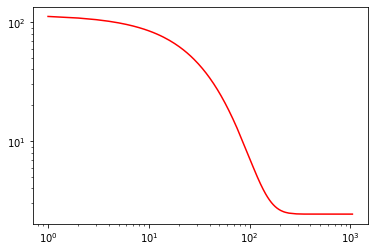

In [31]:
plt.plot(deg, func(np.array(deg), *popt), color='red')
plt.yscale('log')
plt.xscale('log')


##### Provo http://networksciencebook.com/chapter/4#advanced-c


In [40]:
from itertools import count, islice

def binom(n, k):
    v = 1
    for i in range(k):
        v *= (n - i) / (i + 1)
    return v

def zeta(s, t=100):
    if s == 1: return complex("inf")
    term = (1 / 2 ** (n + 1) * sum((-1) ** k * binom(n, k) * (k + 1) ** -s 
                                   for k in range(n + 1)) for n in count(0))
    return sum(islice(term, t)) / (1 - 2 ** (1 - s))

def zeta2(s, t=10000):
    if s == 1: return float("inf")
    #term = ((-1)**(n - 1) / (n ** s) for n in count(1))
    #return sum(islice(term, t)) / (1 - 2**(1 - s))
    term = ((-1) ** n * n ** -s for n in count(1))
    return sum(islice(term, t)) / (2 ** (1 - s) -  1)

def zeta3(s, t=100):
    if s == 1: return float("inf")
    term = (1 / 2 ** (n + 1) * sum((-1) ** k * binom(n, k) * (k + 1) ** -s 
                                   for k in range(n + 1)) for n in count(0))
    return sum(islice(term, t)) / (1 - 2 ** (1 - s))

In [41]:
#from scipy.special import zeta


gamma = 0 # γ
N = nx.number_of_nodes(G)

list_D = {}
pk_list = []

deg = np.array(deg)


for Kmin in deg:
    
    gamma = np.array([np.log(ki/(Kmin-0.5)) for ki in dict(G.degree()).values()], dtype=np.float64()).sum()
    
    gamma = 1 + N / (gamma)
    
    
    pk = lambda gamma, k: 1/(zeta(gamma, Kmin) * k**gamma)
    CDF = lambda gamma, k: (1 - (zeta3(gamma, k))/zeta3(gamma, Kmin))    
    
    D = max([abs( (len(deg[deg <= Kmin])/len(deg)) - CDF(gamma, k)) for k in deg[deg >= Kmin]]) # empirical distribution function - model CDF
    list_D[(gamma, Kmin)] = D

# find Min
best_D= sorted(list_D.items(), key=lambda item: item[1], reverse=True)[0]

print(best_D)

<ipython-input-40-d2943640e0c3>:24: RuntimeWarning: invalid value encountered in double_scalars
  term = (1 / 2 ** (n + 1) * sum((-1) ** k * binom(n, k) * (k + 1) ** -s


KeyboardInterrupt: 

In [ ]:

plt.scatter([ k for g, k in list_D.keys()], list_D.values(), c='m')
plt.xlabel("k")
plt.ylabel("D")

In [37]:

step = 1000

d_list = []
for K in np.arange(1, N, step):

    # load graph with K nodes
    G_p = load_dataset(True, K)
    
    d_list.append(nx.average_shortest_path_length(G))

ValueError: Sample larger than population or is negative

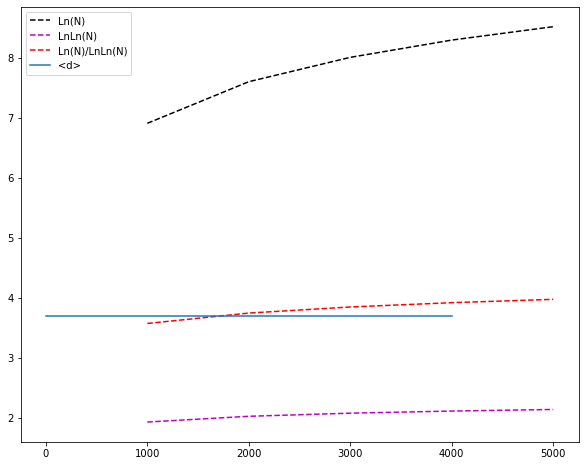

In [39]:
# plot linecharts
plt.figure(figsize=(10, 8))


x_list = np.arange(step, N + step, step)

plt.plot(x_list, [ np.log(x) for x in x_list ], "k--", label = "Ln(N)")
plt.plot(x_list, [ np.log(np.log(x)) for x in x_list ], "m--", label = "LnLn(N)")
plt.plot(x_list, [ np.log(x)/np.log(np.log(x)) for x in x_list ], "r--", label = "Ln(N)/LnLn(N)")
plt.plot(np.arange(1, N, step), d_list, label="<d>")

plt.legend()

#### 2. Which are the most important nodes, with respect to a given centrality measure?

In [ ]:
# da scegliere le misure

k= 10 # top k node

betwenness = nx.betweenness_centrality(G)

# select first k
betwenness = dict(sorted(betwenness.items(), key=lambda item: item[1], reverse=True)[:k])

print(betwenness)

closeness = nx.closeness_centrality(G)

# select first k
closeness = dict(sorted(closeness.items(), key=lambda item: item[1], reverse=True)[:k])

print(closeness)




#### 3. Are the paths short with respect to the size of the network?


In [10]:
print("Diameter: ", nx.diameter(G))
print("Average distance ", nx.average_shortest_path_length(G))


Diameter:  8
Average distance  3.6925068496963913


#### 5. Is the network assortative?

In [ ]:
# da fare più avanti nel corso